# Fock space: 
## JGC quantum-enhanced telescope example
WARNING: NOT COMPLETED

In [1]:
import itertools

import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.fock import BeamSplitter, FockState, Phase
from squint.utils import partition_op

In [ ]:
cutoff = 4
circuit = Circuit()


circuit.add(
    FockState(
        wires=(
            0,
            3,
        ),
        n=[(1 / jnp.sqrt(2).item(), (1, 0)), (1 / jnp.sqrt(2).item(), (0, 1))],
    )
)
circuit.add(Phase(wires=(0,), phi=0.01), "phase")

circuit.add(
    FockState(
        wires=(
            1,
            4,
        ),
        n=[(1 / jnp.sqrt(2).item(), (1, 0)), (1 / jnp.sqrt(2).item(), (0, 1))],
    )
)
circuit.add(
    FockState(
        wires=(
            2,
            5,
        ),
        n=[(1 / jnp.sqrt(2).item(), (1, 0)), (1 / jnp.sqrt(2).item(), (0, 1))],
    )
)

for telescope in (0, 1):
    circuit.add(
        BeamSplitter(
            wires=(
                0 + telescope * 3,
                1 + telescope * 3,
            ),
            r=jnp.pi / 2.1,
        )
    )
    circuit.add(Phase(wires=(0 + telescope * 3,), phi=0.01))
    circuit.add(
        BeamSplitter(
            wires=(
                0 + telescope * 3,
                1 + telescope * 3,
            ),
            r=jnp.pi / 2.1,
        )
    )

    circuit.add(
        BeamSplitter(
            wires=(
                1 + telescope * 3,
                2 + telescope * 3,
            ),
            r=jnp.pi / 2.1,
        )
    )
    circuit.add(Phase(wires=(1 + telescope * 3,), phi=0.01))
    circuit.add(
        BeamSplitter(
            wires=(
                1 + telescope * 3,
                2 + telescope * 3,
            ),
            r=jnp.pi / 2.1,
        )
    )

    circuit.add(
        BeamSplitter(
            wires=(
                0 + telescope * 3,
                1 + telescope * 3,
            ),
            r=jnp.pi / 2.1,
        )
    )
    circuit.add(Phase(wires=(0 + telescope * 3,), phi=0.01))
    circuit.add(
        BeamSplitter(
            wires=(
                0 + telescope * 3,
                1 + telescope * 3,
            ),
            r=jnp.pi / 2.1,
        )
    )

In [ ]:
# params, static = eqx.partition(circuit, eqx.is_inexact_array, is_leaf=lambda leaf: isinstance(leaf, paramax.NonTrainable))
params, static = partition_op(circuit, "phase")
pprint(params)

Circuit(
  ops={
│   0:
│   FockState(wires=(None,), n=[(None, (None,))]),
│   1:
│   FockState(wires=(None,), n=[(None, (None,))]),
│   2:
│   BeamSplitter(wires=(None, None), r=None),
│   'phase':
│   Phase(wires=(None,), phi=weak_f32[]),
│   4:
│   BeamSplitter(wires=(None, None), r=None)
  }
)

2025-03-05 17:48:03.857 | INFO     | squint.circuit:compile:114 -   Complete contraction:  a,b,acbd,ce,efdg->fg
         Naive scaling:  7
     Optimized scaling:  5
      Naive FLOP count:  8.192e+4
  Optimized FLOP count:  3.200e+3
   Theoretical speedup:  2.560e+1
  Largest intermediate:  2.560e+2 elements
--------------------------------------------------------------------------------
scaling        BLAS                current                             remaining
--------------------------------------------------------------------------------
   4           GEMM            acbd,a->cbd                     b,ce,efdg,cbd->fg
   3    GEMV/EINSUM              cbd,b->cd                        ce,efdg,cd->fg
   5           GEMM          efdg,ce->fdgc                           cd,fdgc->fg
   4    GEMV/EINSUM            fdgc,cd->fg                                fg->fg


[[0.         0.         0.07322331 0.        ]
 [0.         0.8535535  0.         0.        ]
 [0.07322331 0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
[[[ 0.          0.          0.35355338  0.        ]
  [ 0.         -0.7071069   0.          0.        ]
  [ 0.3535534   0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]]
[[4.]]


Circuit(
  ops={
│   0:
│   FockState(wires=(None,), n=[(None, (None,))]),
│   1:
│   FockState(wires=(None,), n=[(None, (None,))]),
│   2:
│   BeamSplitter(wires=(None, None), r=None),
│   'phase':
│   Phase(wires=(None,), phi=f32[100,1]),
│   4:
│   BeamSplitter(wires=(None, None), r=None)
  }
)

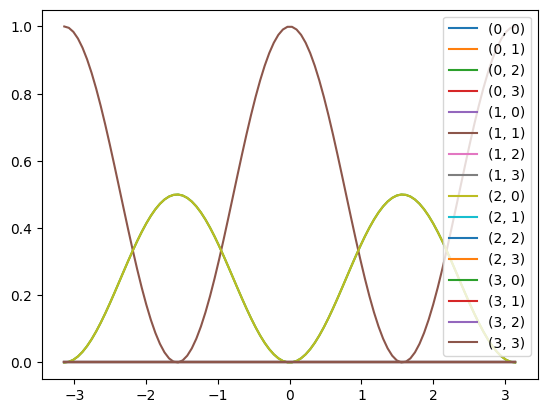

In [19]:
sim = circuit.compile(params, static, dim=cut, optimize="greedy").jit()

grad = get(sim.prob.grad(params))
pr = sim.prob.forward(params)

print(pr)
print(grad)

grad**2 / (pr + 1e-14)
cfim = sim.prob.cfim(get, params)
print(cfim)

get = lambda pytree: jnp.array([pytree.ops["phase"].phi])

phis = jnp.linspace(-jnp.pi, jnp.pi, 100)
params = eqx.tree_at(
    lambda pytree: pytree.ops["phase"].phi, params, jnp.expand_dims(phis, axis=1)
)
pprint(params)
probs = eqx.filter_vmap(sim.prob.forward)(params)
# cfims = eqx.filter_vmap(sim.prob.cfim, in_axes=(None, 0))(get, params)
# print(cfims)


colors = sns.color_palette(n_colors=jnp.prod(jnp.array(probs.shape[1:])))
fig, ax = plt.subplots()
for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    ax.plot(phis, probs[:, *idx], label=f"{idx}", color=colors[i])
ax.legend()


# fig, ax = plt.subplots()
# ax.plot(phis, cfims.squeeze(), color=colors[i])